In [1]:
# Add at the top of the notebook
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/data-valuation/
!pip install -qr requirements.txt

Mounted at /content/drive
/content/drive/MyDrive/data-valuation
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 2.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.2/380.2 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.9/105.9 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

# MNIST data valuation notebook

---

This notebook compares two methods of calculating the "diversity" measure
1. Difference-based diversity
2. Volume-based diversity

The basic algorithm of our data valuation method for a buyer's and seller's dataset
0. Embed the data in representation space with a pretrained model (optional)
1. Compute the buyer's components and values (eigendecomposition of the covariance matrix i.e. PCA)
2. Project the seller's data onto the buyer's components
3. Calculate "diversity" and "relevance" based off the buyer's and seller's magnitude's of theier eigenvalues
    * relevance is the $\prod_{i\in \text{C}}\min\left(\|\lambda^\text{buyer}_i\|, \|\hat{\lambda}^\text{seller}_i\|\right)$
    * diversity can be calculated in two ways
        1. the difference $\prod_{i\in \text{C}}\big|\|\lambda^\text{buyer}_i\| - \|\hat{\lambda}^\text{seller}_i\|\big|$
        2. the volume $\sqrt{\det(X_\text{seller}^T X_\text{seller})}$


Various comparisons between difference- and volume-diversity are made on the MNIST dataset in this notebook

## Module imports

In [2]:
from importlib import reload
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '2'
import math
import collections
from pathlib import Path
import numpy as np
import torch
from torchvision.datasets import EMNIST, MNIST, SVHN, FashionMNIST, CIFAR10
from torchvision.models import resnet18, ResNet18_Weights, resnet34, ResNet34_Weights, resnet50, ResNet50_Weights
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
import matplotlib
import matplotlib.pyplot as plt; plt.style.use('bmh')
from matplotlib import rcParams; rcParams['font.family'] = 'serif'

# local imports
from data import subset
import valuation
reload(valuation)
# from valuation import get_volume, div_rel_func
import utils

## Make buyer and seller datasets

In [4]:
root = Path('../data/') # path to data directory
download = True # dowload data if dataset does not exist in data directory

# ds = SVHN(root=root, download=download)
mnist_buyer = MNIST(root=root, train=False, download=download)
mnist_seller = MNIST(root=root, train=True, download=download)
fashion = FashionMNIST(root=root, train=False, download=download)
cifar = CIFAR10(root=root, train=False, download=download)
emnist = EMNIST(root=root, split='byclass', train=False, download=download)

Files already downloaded and verified


In [5]:
import chromadb
client = chromadb.Client()

In [6]:
collection = client.create_collection("sciq_supports")

In [ ]:
# from langchain.embeddings.openai import OpenAIEmbeddings
# from langchain.vectorstores import Chroma

# # Load the document, split it into chunks, embed each chunk and load it into the vector store.
# documents = cifar.data
# db = Chroma.from_documents(documents, OpenAIEmbeddings())

In [7]:
data = cifar.data

In [46]:
start_dim = 0
end_dim = 100 # change this up to data.shape[0]
collection.add(
    ids = [str(i) for i in range(start_dim, end_dim)],  # Generating string IDs
    images = [str(data[i]) for i in range(start_dim, end_dim)],  # Extracting images from the dataset
)

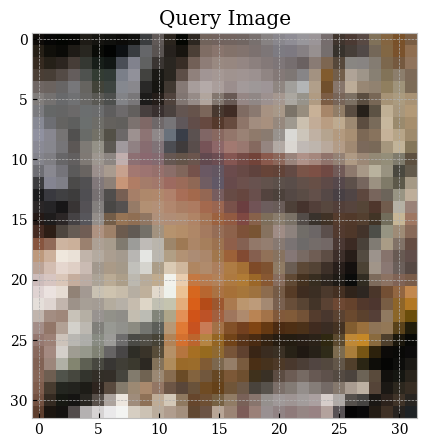

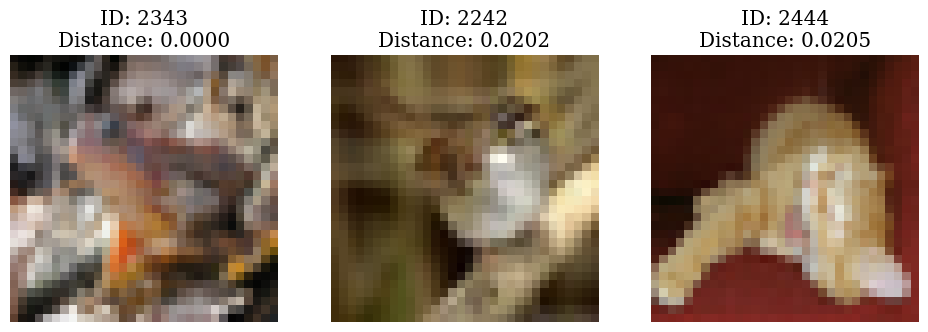

In [49]:
def display_similar(index, top_k = 3):
  results = collection.query(
      query_texts = str(data[index]),
      n_results=top_k)

  plt.figure(figsize=(5, 5))  # Adjust the size as needed
  plt.imshow(data[index])
  plt.title("Query Image")
  plt.show()

  # Number of images to display
  num_images = len(results['ids'][0])

  # Create a figure with subplots
  plt.figure(figsize=(20, 20))  # Adjust the size as needed

  # Loop through the results and create a subplot for each image
  for i in range(num_images):
      # Parse the ID and get the corresponding image from 'data'
      image_id = results['ids'][0][i]
      image = data[int(image_id)]
      distance = results['distances'][0][i]

      # Create a subplot
      plt.subplot(num_images // 5 + 1, 5, i + 1)  # Adjust the number of columns to your preference
      plt.imshow(image)
      plt.title(f'ID: {image_id}\nDistance: {distance:.4f}')
      plt.axis('off')  # Hide the axis

  # Show the plot with all subplots
  plt.show()

display_similar(2343)

# Other stuff

In [ ]:
# partition data by class label
buyer_index = subset(mnist_buyer, ('0 - zero', '1 - one', '2 - two', '3 - three', '4 - four'))
seller1_index = subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '3 - three', '4 - four'))
seller2_index = subset(mnist_seller, ('1 - one', '2 - two', '3 - three', '4 - four', '5 - five'))
seller3_index = subset(mnist_seller, ('2 - two', '3 - three', '4 - four', '5 - five', '6 - six'))
seller4_index = subset(mnist_seller, ('3 - three', '4 - four', '5 - five', '6 - six', '7 - seven'))
seller5_index = subset(mnist_seller, ('4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight'))
seller6_index = subset(mnist_seller, ('5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine'))
seller7_index = subset(mnist_seller, ('0 - zero', ))
seller8_index = subset(mnist_seller, ('5 - five', ))
seller9_index = subset(mnist_seller, ('0 - zero', '5 - five'))
seller10_index = subset(mnist_seller, ('0 - zero', '1 - one', '5 - five', '6 - six'))
seller11_index = subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '5 - five', '6 - six', '7 - seven'))
seller12_index = subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '3 - three', '5 - five', '6 - six', '7 - seven', '8 - eight'))
seller13_index = subset(mnist_seller, ('0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine'))

emnist_index = subset(emnist, ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z'))


buyer_samples = 100
seller_samples = 10000

buyer_data = (mnist_buyer.data[buyer_index] / 255) [:buyer_samples]
seller1_data = (mnist_seller.data[seller1_index] / 255) [:seller_samples]
seller2_data = (mnist_seller.data[seller2_index] / 255) [:seller_samples]
seller3_data = (mnist_seller.data[seller3_index] / 255) [:seller_samples]
seller4_data = (mnist_seller.data[seller4_index] / 255) [:seller_samples]
seller5_data = (mnist_seller.data[seller5_index] / 255) [:seller_samples]
seller6_data = (mnist_seller.data[seller6_index] / 255) [:seller_samples]
seller7_data = (mnist_seller.data[seller7_index] / 255) [:seller_samples]
seller8_data = (mnist_seller.data[seller8_index] / 255) [:seller_samples]
seller9_data = (mnist_seller.data[seller9_index] / 255) [:seller_samples]
seller10_data = (mnist_seller.data[seller10_index] / 255) [:seller_samples]
seller11_data = (mnist_seller.data[seller11_index] / 255) [:seller_samples]
seller12_data = (mnist_seller.data[seller12_index] / 255) [:seller_samples]
seller13_data = (mnist_seller.data[seller13_index] / 255) [:seller_samples]

seller_fashion_data = (fashion.data / 255) [:seller_samples]
seller_cifar_data = torch.tensor(cifar.data / 255, dtype=torch.float) [:seller_samples]
seller_emnist_data = (emnist.data[emnist_index] / 255) [:seller_samples]

# flatten dimension from 1x28x28 to 1x784
buyer_data_flat = buyer_data.reshape(-1, 28*28)
seller1_data_flat = seller1_data.reshape(-1, 28*28)
seller2_data_flat = seller2_data.reshape(-1, 28*28)
seller3_data_flat = seller3_data.reshape(-1, 28*28)
seller4_data_flat = seller4_data.reshape(-1, 28*28)
seller5_data_flat = seller5_data.reshape(-1, 28*28)
seller6_data_flat = seller6_data.reshape(-1, 28*28)
seller7_data_flat = seller7_data.reshape(-1, 28*28)
seller8_data_flat = seller8_data.reshape(-1, 28*28)
seller9_data_flat = seller9_data.reshape(-1, 28*28)
seller10_data_flat = seller10_data.reshape(-1, 28*28)
seller11_data_flat = seller11_data.reshape(-1, 28*28)
seller12_data_flat = seller12_data.reshape(-1, 28*28)
seller13_data_flat = seller13_data.reshape(-1, 28*28)

seller_fashion_data_flat = seller_fashion_data.reshape(-1, 28*28)
seller_cifar_data_flat = seller_cifar_data.reshape(-1, 32*32)
seller_emnist_data_flat = seller_emnist_data.reshape(-1, 28*28)

In [ ]:
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(seller6_data[0])
ax[1].imshow(seller6_data[500])

In [ ]:
# copy data to measure robustness to duplication
n = seller1_data.shape[0]
dup1_data = seller1_data[:int(n // 2)].repeat(2, 1, 1) # 50% original
dup2_data = seller1_data[:int(n // 4)].repeat(4, 1, 1) # 25% original
dup3_data = seller1_data[:int(n // 20)].repeat(20, 1, 1) # 5% original
dup4_data = seller1_data[:int(n // 50)].repeat(50, 1, 1) # 2% original
dup1_data.shape, dup2_data.shape, dup3_data.shape, dup4_data.shape

dup1_data_flat = dup1_data.reshape(-1, 28*28)
dup2_data_flat = dup2_data.reshape(-1, 28*28)
dup3_data_flat = dup3_data.reshape(-1, 28*28)
dup4_data_flat = dup4_data.reshape(-1, 28*28)

In [ ]:
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(dup1_data[0])
ax[1].imshow(dup1_data[seller_samples//2])

In [ ]:
# mixture of MNIST and FashionMNIST datasets
mix1_data = torch.cat([seller1_data[:int(seller_samples * 0.9)], seller_fashion_data[:int(seller_samples * 0.1)]])
mix2_data = torch.cat([seller1_data[:int(seller_samples * 0.8)], seller_fashion_data[:int(seller_samples * 0.2)]])
mix3_data = torch.cat([seller1_data[:int(seller_samples * 0.7)], seller_fashion_data[:int(seller_samples * 0.3)]])
mix4_data = torch.cat([seller1_data[:int(seller_samples * 0.6)], seller_fashion_data[:int(seller_samples * 0.4)]])
mix5_data = torch.cat([seller1_data[:int(seller_samples * 0.5)], seller_fashion_data[:int(seller_samples * 0.5)]])
mix6_data = torch.cat([seller1_data[:int(seller_samples * 0.4)], seller_fashion_data[:int(seller_samples * 0.6)]])
mix7_data = torch.cat([seller1_data[:int(seller_samples * 0.3)], seller_fashion_data[:int(seller_samples * 0.7)]])
mix8_data = torch.cat([seller1_data[:int(seller_samples * 0.2)], seller_fashion_data[:int(seller_samples * 0.8)]])
mix9_data = torch.cat([seller1_data[:int(seller_samples * 0.1)], seller_fashion_data[:int(seller_samples * 0.9)]])

mix1_data_flat = mix1_data.reshape(-1, 28*28)
mix2_data_flat = mix2_data.reshape(-1, 28*28)
mix3_data_flat = mix3_data.reshape(-1, 28*28)
mix4_data_flat = mix4_data.reshape(-1, 28*28)
mix5_data_flat = mix5_data.reshape(-1, 28*28)
mix6_data_flat = mix6_data.reshape(-1, 28*28)
mix7_data_flat = mix7_data.reshape(-1, 28*28)
mix8_data_flat = mix8_data.reshape(-1, 28*28)
mix9_data_flat = mix9_data.reshape(-1, 28*28)

In [ ]:
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(mix5_data[0])
ax[1].imshow(mix5_data[seller_samples//2])

In [ ]:
upsample = lambda x: torch.nn.Upsample(scale_factor=2)(x)

### load pretrained model to embed data

In [ ]:
assert torch.cuda.is_available()

In [ ]:
# model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1).cuda()
model = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1).cuda()
# model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1).cuda()
model.eval();

In [ ]:
batch_size = 64
buyer_loader = torch.utils.data.DataLoader(upsample(buyer_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
seller1_loader = torch.utils.data.DataLoader(upsample(seller1_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
seller2_loader = torch.utils.data.DataLoader(upsample(seller2_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
seller3_loader = torch.utils.data.DataLoader(upsample(seller3_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
seller4_loader = torch.utils.data.DataLoader(upsample(seller4_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
seller5_loader = torch.utils.data.DataLoader(upsample(seller5_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
seller6_loader = torch.utils.data.DataLoader(upsample(seller6_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
seller7_loader = torch.utils.data.DataLoader(upsample(seller7_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
seller8_loader = torch.utils.data.DataLoader(upsample(seller8_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
seller9_loader = torch.utils.data.DataLoader(upsample(seller9_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
seller10_loader = torch.utils.data.DataLoader(upsample(seller10_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
seller11_loader = torch.utils.data.DataLoader(upsample(seller11_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
seller12_loader = torch.utils.data.DataLoader(upsample(seller12_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
seller13_loader = torch.utils.data.DataLoader(upsample(seller13_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)

seller_fashion_loader = torch.utils.data.DataLoader(upsample(seller_fashion_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
seller_emnist_loader = torch.utils.data.DataLoader(upsample(seller_emnist_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
seller_cifar_loader = torch.utils.data.DataLoader(upsample(seller_cifar_data.moveaxis(-1, 1)), batch_size=batch_size)

In [ ]:
dup1_loader = torch.utils.data.DataLoader(upsample(dup1_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
dup2_loader = torch.utils.data.DataLoader(upsample(dup2_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
dup3_loader = torch.utils.data.DataLoader(upsample(dup3_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
dup4_loader = torch.utils.data.DataLoader(upsample(dup4_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)

mix1_loader = torch.utils.data.DataLoader(upsample(mix1_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
mix2_loader = torch.utils.data.DataLoader(upsample(mix2_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
mix3_loader = torch.utils.data.DataLoader(upsample(mix3_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
mix4_loader = torch.utils.data.DataLoader(upsample(mix4_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
mix5_loader = torch.utils.data.DataLoader(upsample(mix5_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
mix6_loader = torch.utils.data.DataLoader(upsample(mix6_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
mix7_loader = torch.utils.data.DataLoader(upsample(mix7_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
mix8_loader = torch.utils.data.DataLoader(upsample(mix8_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)
mix9_loader = torch.utils.data.DataLoader(upsample(mix9_data.unsqueeze(1).repeat(1, 3, 1, 1)), batch_size=batch_size)

In [ ]:
buyer_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(buyer_loader)])
seller1_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(seller1_loader)])
seller2_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(seller2_loader)])
seller3_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(seller3_loader)])
seller4_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(seller4_loader)])
seller5_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(seller5_loader)])
seller6_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(seller6_loader)])
seller7_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(seller7_loader)])
seller8_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(seller8_loader)])
seller9_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(seller9_loader)])
seller10_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(seller10_loader)])
seller11_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(seller11_loader)])
seller12_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(seller12_loader)])
seller13_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(seller13_loader)])

seller_fashion_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(seller_fashion_loader)])
seller_emnist_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(seller_emnist_loader)])
seller_cifar_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(seller_cifar_loader)])

In [ ]:
dup1_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(dup1_loader)])
dup2_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(dup2_loader)])
dup3_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(dup3_loader)])
dup4_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(dup4_loader)])

mix1_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(mix1_loader)])
mix2_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(mix2_loader)])
mix3_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(mix3_loader)])
mix4_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(mix4_loader)])
mix5_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(mix5_loader)])
mix6_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(mix6_loader)])
mix7_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(mix7_loader)])
mix8_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(mix8_loader)])
mix9_features = torch.cat([model(x.cuda()).detach().cpu() for x in iter(mix9_loader)])

In [ ]:
torch.cuda.empty_cache()

## Data valuation with diversity and relevance measures

In [ ]:
# number of PCA components to use
# n_components = 2
# n_components = 5
n_components = 10
# n_components = 15
# n_components = 20
# n_components = 50

# whether to use pretrained image features or raw data
# use_features = True
use_features = False

In [ ]:
X_b = buyer_features.float() if use_features else buyer_data_flat.float()
X_b -= X_b.mean(0)

X_s = seller_1_features.float() if use_features else seller1_data_flat.float()
X_s -= X_s.mean(0)


buyer_cov = np.cov(X_b, rowvar=False)

# eigendecomposition of buyer's covariance matrix
buyer_eig_val, buyer_eig_vec = np.linalg.eig(buyer_cov)

# sort by decreasing eigenvalues
sorted_indices = np.argsort(buyer_eig_val)[::-1]
buyer_values = buyer_eig_val[sorted_indices].real
buyer_components = buyer_eig_vec[:, sorted_indices].real

print(f'first {n_components} components using numpy:', buyer_values[:n_components])

# project seller covariance onto buyer's components
np.linalg.norm(np.cov(X_s, rowvar=False) @ buyer_components[:, :n_components], axis=0)

**We can also use sklearn's implmentation of PCA to get the same results**

In [ ]:
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=False)
pca.fit(X_b)

buyer_values = pca.explained_variance_
buyer_components = pca.components_

# PCA stores mean of previously fitted buyer's data; clear it since we already zero mean the seller data
pca.mean_ = None

print(f'first {n_components} components using sklearn:', buyer_values)
np.linalg.norm(pca.transform(np.cov(X_s, rowvar=False)), axis=0)
# pca.transform(X_b)

In [ ]:
X_1 = seller1_features if use_features else seller1_data_flat.float()
X_1 -= X_1.mean(0)
seller1_cov = np.cov(X_1.T)

X_2 = seller2_features if use_features else seller2_data_flat.float()
X_2 -= X_2.mean(0)
seller2_cov = np.cov(X_2.T)

X_3 = seller3_features if use_features else seller3_data_flat.float()
X_3 -= X_3.mean(0)
seller3_cov = np.cov(X_3.T)

X_4 = seller4_features if use_features else seller4_data_flat.float()
X_4 -= X_4.mean(0)
seller4_cov = np.cov(X_4.T)

X_5 = seller5_features if use_features else seller5_data_flat.float()
X_5 -= X_5.mean(0)
seller5_cov = np.cov(X_5.T)

X_6 = seller6_features if use_features else seller6_data_flat.float()
X_6 -= X_6.mean(0)
seller6_cov = np.cov(X_6.T)

X_7 = seller7_features if use_features else seller7_data_flat.float()
X_7 -= X_7.mean(0)
seller7_cov = np.cov(X_7.T)

X_8 = seller8_features if use_features else seller8_data_flat.float()
X_8 -= X_8.mean(0)
seller8_cov = np.cov(X_8.T)

X_9 = seller9_features if use_features else seller9_data_flat.float()
X_9 -= X_9.mean(0)
seller9_cov = np.cov(X_9.T)

X_10 = seller10_features if use_features else seller10_data_flat.float()
X_10 -= X_10.mean(0)
seller10_cov = np.cov(X_10.T)

X_11 = seller11_features if use_features else seller11_data_flat.float()
X_11 -= X_11.mean(0)
seller11_cov = np.cov(X_11.T)

X_12 = seller12_features if use_features else seller12_data_flat.float()
X_12 -= X_12.mean(0)
seller12_cov = np.cov(X_12.T)

X_13 = seller13_features if use_features else seller13_data_flat.float()
X_13 -= X_13.mean(0)
seller13_cov = np.cov(X_13.T)

X_fashion = seller_fashion_features if use_features else seller_fashion_data_flat.float()
X_fashion -= X_fashion.mean(0)
seller_fashion_cov = np.cov(X_fashion.T)

X_cifar = seller_cifar_features if use_features else seller_cifar_data_flat.float()
X_cifar -= X_cifar.mean(0)
seller_cifar_cov = np.cov(X_cifar.T)

X_emnist = seller_emnist_features if use_features else seller_emnist_data_flat.float()
X_emnist -= X_emnist.mean(0)
seller_emnist_cov = np.cov(X_emnist.T)


In [ ]:
X_dup1 = dup1_features if use_features else dup1_data_flat.float()
X_dup1 -= X_dup1.mean(0)
dup1_cov = np.cov(X_dup1.T)

X_dup2 = dup2_features if use_features else dup2_data_flat.float()
X_dup2 -= X_dup2.mean(0)
dup2_cov = np.cov(X_dup2.T)

X_dup3 = dup3_features if use_features else dup3_data_flat.float()
X_dup3 -= X_dup3.mean(0)
dup3_cov = np.cov(X_dup3.T)

X_dup4 = dup4_features if use_features else dup4_data_flat.float()
X_dup4 -= X_dup4.mean(0)
dup4_cov = np.cov(X_dup4.T)

X_mix1 = mix1_features if use_features else mix1_data_flat.float()
X_mix1 -= X_mix1.mean(0)
mix1_cov = np.cov(X_mix1.T)

X_mix2 = mix2_features if use_features else mix2_data_flat.float()
X_mix2 -= X_mix2.mean(0)
mix2_cov = np.cov(X_mix2.T)

X_mix3 = mix3_features if use_features else mix3_data_flat.float()
X_mix3 -= X_mix3.mean(0)
mix3_cov = np.cov(X_mix3.T)

X_mix4 = mix4_features if use_features else mix4_data_flat.float()
X_mix4 -= X_mix4.mean(0)
mix4_cov = np.cov(X_mix4.T)

X_mix5 = mix5_features if use_features else mix5_data_flat.float()
X_mix5 -= X_mix5.mean(0)
mix5_cov = np.cov(X_mix5.T)

X_mix6 = mix6_features if use_features else mix6_data_flat.float()
X_mix6 -= X_mix6.mean(0)
mix6_cov = np.cov(X_mix6.T)

X_mix7 = mix7_features if use_features else mix7_data_flat.float()
X_mix7 -= X_mix7.mean(0)
mix7_cov = np.cov(X_mix7.T)

X_mix8 = mix8_features if use_features else mix8_data_flat.float()
X_mix8 -= X_mix8.mean(0)
mix8_cov = np.cov(X_mix8.T)

X_mix9 = mix9_features if use_features else mix9_data_flat.float()
X_mix9 -= X_mix9.mean(0)
mix9_cov = np.cov(X_mix9.T)

### Compute volume-based diversity measure on projected data

In [ ]:
# normalize samples (rows) to have unit norm
normalize = True
if normalize:
    Norm = Normalizer(norm='l2')
    X_1 = Norm.fit_transform(X_1.clone())
    X_2 = Norm.fit_transform(X_2.clone())
    X_3 = Norm.fit_transform(X_3.clone())
    X_4 = Norm.fit_transform(X_4.clone())
    X_5 = Norm.fit_transform(X_5.clone())
    X_6 = Norm.fit_transform(X_6.clone())
    X_7 = Norm.fit_transform(X_7.clone())
    X_8 = Norm.fit_transform(X_8.clone())
    X_9 = Norm.fit_transform(X_9.clone())
    X_10 = Norm.fit_transform(X_10.clone())
    X_11 = Norm.fit_transform(X_11.clone())
    X_12 = Norm.fit_transform(X_12.clone())
    X_13 = Norm.fit_transform(X_13.clone())
    X_fashion = Norm.fit_transform(X_fashion.clone())
    X_emnist = Norm.fit_transform(X_emnist.clone())
    X_cifar = Norm.fit_transform(X_cifar.clone())
    X_dup1 = Norm.fit_transform(X_dup1.clone())
    X_dup2 = Norm.fit_transform(X_dup2.clone())
    X_dup3 = Norm.fit_transform(X_dup3.clone())
    X_dup4 = Norm.fit_transform(X_dup4.clone())
    X_mix1 = Norm.fit_transform(X_mix1.clone())
    X_mix2 = Norm.fit_transform(X_mix2.clone())
    X_mix3 = Norm.fit_transform(X_mix3.clone())
    X_mix4 = Norm.fit_transform(X_mix4.clone())
    X_mix5 = Norm.fit_transform(X_mix5.clone())
    X_mix6 = Norm.fit_transform(X_mix6.clone())
    X_mix7 = Norm.fit_transform(X_mix7.clone())
    X_mix8 = Norm.fit_transform(X_mix8.clone())
    X_mix9 = Norm.fit_transform(X_mix9.clone())

In [ ]:
# hyperparameter for volume-based diversity meausre
# controls robustness to data duplication
# in range (0, 1); higher values increase robustness
# see paper for more info https://proceedings.neurips.cc/paper/2021/hash/59a3adea76fadcb6dd9e54c96fc155d1-Abstract.html

omegas = np.arange(0.1, 1, 0.2)
vol_full = [get_volume(pca.transform(X_1), omega=omega) for omega in omegas]
vol_dup1 = [get_volume(pca.transform(X_dup1), omega=omega) for omega in omegas]
vol_dup2 = [get_volume(pca.transform(X_dup2), omega=omega) for omega in omegas]
vol_dup3 = [get_volume(pca.transform(X_dup3), omega=omega) for omega in omegas]
vol_dup4 = [get_volume(pca.transform(X_dup4), omega=omega) for omega in omegas]

In [ ]:
plt.figure()
plt.plot(omegas, vol_full, label=r'Seller mnist $1–5$ (0% duplicated)')
plt.plot(omegas, vol_dup1, label=r'Seller mnist $1-5$ (50% duplicated)')
plt.plot(omegas, vol_dup2, label=r'Seller mnist $1-5$ (75% duplicated)')
plt.plot(omegas, vol_dup3, label=r'Seller mnist $1-5$ (95% duplicated)')
plt.plot(omegas, vol_dup4, label=r'Seller mnist $1-5$ (99% duplicated)')
plt.legend()
plt.yscale('log', base=2)
plt.xlabel(r'$\omega$', fontsize=14)
plt.ylabel(r'Volume', fontsize=14, rotation=0)

In [ ]:
omega = 0.1
# omega = 0.3
# omega = 0.5
# omega = 0.7

buyer_vol = get_volume(pca.transform(X_b), omega=omega)
seller1_vol = get_volume(pca.transform(X_1), omega=omega)
seller2_vol = get_volume(pca.transform(X_2), omega=omega)
seller3_vol = get_volume(pca.transform(X_3), omega=omega)
seller4_vol = get_volume(pca.transform(X_4), omega=omega)
seller5_vol = get_volume(pca.transform(X_5), omega=omega)
seller6_vol = get_volume(pca.transform(X_6), omega=omega)
seller7_vol = get_volume(pca.transform(X_7), omega=omega)
seller8_vol = get_volume(pca.transform(X_8), omega=omega)
seller9_vol = get_volume(pca.transform(X_9), omega=omega)
seller10_vol = get_volume(pca.transform(X_10), omega=omega)
seller11_vol = get_volume(pca.transform(X_11), omega=omega)
seller12_vol = get_volume(pca.transform(X_12), omega=omega)
seller13_vol = get_volume(pca.transform(X_13), omega=omega)
seller_fashion_vol = get_volume(pca.transform(X_fashion), omega=omega)
seller_emnist_vol = get_volume(pca.transform(X_emnist), omega=omega)
if use_features:
    seller_cifar_vol = get_volume(pca.transform(X_cifar), omega=omega)
dup1_vol = get_volume(pca.transform(X_dup1), omega=omega)
dup2_vol = get_volume(pca.transform(X_dup2), omega=omega)
dup3_vol = get_volume(pca.transform(X_dup3), omega=omega)
dup4_vol = get_volume(pca.transform(X_dup4), omega=omega)
mix1_vol = get_volume(pca.transform(X_mix1), omega=omega)
mix2_vol = get_volume(pca.transform(X_mix2), omega=omega)
mix3_vol = get_volume(pca.transform(X_mix3), omega=omega)
mix4_vol = get_volume(pca.transform(X_mix4), omega=omega)
mix5_vol = get_volume(pca.transform(X_mix5), omega=omega)
mix6_vol = get_volume(pca.transform(X_mix6), omega=omega)
mix7_vol = get_volume(pca.transform(X_mix7), omega=omega)
mix8_vol = get_volume(pca.transform(X_mix8), omega=omega)
mix9_vol = get_volume(pca.transform(X_mix9), omega=omega)

In [ ]:
# only consider directions where the eigenvalue is larger than this threshold in the computation of diversity and relevance
threshold = 0.1
# threshold = 0.2
# threshold = 0.3

kwargs = {'threshold': threshold, 'n_components': n_components}

In [ ]:
# where to save plots
figures = Path('figures')
figures.mkdir(exist_ok=True, parents=True)

### Compare diversity measures when sellers have different amounts of overlapping classes

In [ ]:
cividis = [np.array([matplotlib.colormaps['cividis'].colors[int(k)]]) for k in np.linspace(255, 0, 6)]

fontsize = 32
s = 500

fig, ax = plt.subplots(figsize=(16, 8), ncols=2)

ax[0].scatter(*div_rel_func(buyer_values, buyer_components, buyer_cov, **kwargs),   c='#0072B2', edgecolor='k', s=s, label=r'Buyer MNIST $0–4$')

ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller1_cov, **kwargs), c=cividis[0], edgecolor='k', s=s, label=r'Seller mnist $0–4$')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller2_cov, **kwargs), c=cividis[1], edgecolor='k', s=s, label=r'Seller mnist $1–5$')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller3_cov, **kwargs), c=cividis[2], edgecolor='k', s=s, label=r'Seller mnist $2–6$')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller4_cov, **kwargs), c=cividis[3], edgecolor='k', s=s, label=r'Seller mnist $3–7$')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller5_cov, **kwargs), c=cividis[4], edgecolor='k', s=s, label=r'Seller mnist $4–8$')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller6_cov, **kwargs), c=cividis[5], edgecolor='k', s=s, label=r'Seller mnist $5–9$')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller_emnist_cov, **kwargs), c='C2', edgecolor='k', s=s, marker='D', label=r'Seller emnist')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller_fashion_cov, **kwargs), c='C1', edgecolor='k', s=s, marker='s', label=r'Seller fashion')
if use_features:
    ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller_cifar_cov, **kwargs), edgecolor='k', s=s, marker='^', label=r'Seller Cifar')

ax[0].set_xlim(0, 1.05)
ax[0].set_ylim(-0.05, 1)
ax[0].plot(np.arange(0, 1.1, 0.1), 1 - np.arange(0, 1.1, 0.1), marker='', markersize = 4, markeredgewidth=1.5, color='black', linestyle='--', linewidth=1)
ax[0].set_xlabel('Relevance', fontsize=fontsize, labelpad=6)
ax[0].set_ylabel('Difference', fontsize=fontsize, labelpad=6)
ax[0].set_xticklabels([f'{x:.1f}' for x in ax[0].get_xticks()], fontsize=fontsize-8)
ax[0].set_yticklabels([f'{y:.1f}' for y in ax[0].get_yticks()], fontsize=fontsize-8)
ax[0].tick_params(axis='both', which='major', pad=10)

ax[1].scatter(div_rel_func(buyer_values, buyer_components, buyer_cov, **kwargs)[0],   buyer_vol,   c='#0072B2', edgecolor='k', s=s, label=r'Buyer (MNIST $0–4$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller1_cov, **kwargs)[0], seller1_vol, c=cividis[0], edgecolor='k', s=s, label=r'Seller 1 (MNIST $0–4$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller2_cov, **kwargs)[0], seller1_vol, c=cividis[1], edgecolor='k', s=s, label=r'Seller 2 (MNIST $1–5$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller3_cov, **kwargs)[0], seller2_vol, c=cividis[2], edgecolor='k', s=s, label=r'Seller 3 (MNIST $2–6$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller4_cov, **kwargs)[0], seller3_vol, c=cividis[3], edgecolor='k', s=s, label=r'Seller 4 (MNIST $3–7$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller5_cov, **kwargs)[0], seller4_vol, c=cividis[4], edgecolor='k', s=s, label=r'Seller 5 (MNIST $4–8$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller6_cov, **kwargs)[0], seller5_vol, c=cividis[5], edgecolor='k', s=s, label=r'Seller 6 (MNIST $5–9$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller_emnist_cov, **kwargs)[0], seller_emnist_vol, c='C2', edgecolor='k', s=s, marker='D', label=r'Seller 7 (EMNIST A-Z)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller_fashion_cov, **kwargs)[0], seller_fashion_vol, c='C1', edgecolor='k', s=s, marker='s', label=r'Seller 8 (FashionMNIST)')
if use_features:
    ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller_cifar_cov, **kwargs)[0], seller_cifar_vol, edgecolor='k', s=s, marker='^', label=r'Seller cifar')

ax[1].set_xlim(0, 1.05)
# ax[1].set_ylim(-0.05, ax[1].get_ylim()[1])
# ax[0].set_ylim(-0.05, 1.05)
ax[1].set_xlabel('Relevance', fontsize=32, labelpad=6)
ax[1].set_ylabel('Volume', fontsize=32, labelpad=6)
ax[1].set_xticklabels([f'{x:.1f}' for x in ax[1].get_xticks()], fontsize=fontsize-8)
ax[1].set_yticklabels([y for y in ax[1].get_yticks()], fontsize=fontsize-8)
ax[1].set_yscale('log',base=2)
ax[1].tick_params(axis='both', which='major', pad=10)

plt.tight_layout(pad=4)
plt.legend(prop={'size': fontsize-4}, bbox_to_anchor=(1.04, 1.04))
plt.savefig(figures / f'mnist-compare-diversity-overlap-{"features-" if use_features else ""}n_components-{n_components}-omega-{omega}-threshold-{threshold}.pdf', bbox_inches='tight')
plt.show()

### Compare diversity measures when sellers have increasing number of unique classes

In [ ]:
viridis = [np.array([matplotlib.colormaps['viridis'].colors[int(k)]]) for k in np.linspace(0, 255, 7)]

fontsize = 32
s = 500

fig, ax = plt.subplots(figsize=(18, 8), ncols=2)

ax[0].scatter(*div_rel_func(buyer_values, buyer_components, buyer_cov, **kwargs),   c='#0072B2', edgecolor='k', s=s, label=r'Buyer MNIST $0–4$')

ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller7_cov, **kwargs), c=viridis[0], edgecolor='k', s=s)
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller8_cov, **kwargs), c=viridis[1], edgecolor='k', s=s)
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller9_cov, **kwargs), c=viridis[2], edgecolor='k', s=s)
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller10_cov, **kwargs), c=viridis[3], edgecolor='k', s=s)
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller11_cov, **kwargs), c=viridis[4], edgecolor='k', s=s)
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller12_cov, **kwargs), c=viridis[5], edgecolor='k', s=s)
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller13_cov, **kwargs), c=viridis[6], edgecolor='k', s=s)
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller_emnist_cov, **kwargs), c='C2', edgecolor='k', s=s, marker='D')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller_fashion_cov, **kwargs), c='C1', edgecolor='k', s=s, marker='s')
if use_features:
    ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller_cifar_cov, **kwargs), edgecolor='k', s=s, marker='^')

# ax[0].set_xlim(0.5, 1.05)
# ax[0].set_ylim(-0.02, 0.5)
ax[0].plot(np.arange(0, 1.1, 0.1), 1 - np.arange(0, 1.1, 0.1), marker='', markersize = 4, markeredgewidth=1.5, color='black', linestyle='--', linewidth=1)
ax[0].set_xlabel('Relevance', fontsize=fontsize, labelpad=6)
ax[0].set_ylabel('Difference', fontsize=fontsize, labelpad=6)
ax[0].set_xticklabels([f'{x:.1f}' for x in ax[0].get_xticks()], fontsize=fontsize-8)
ax[0].set_yticklabels([f'{y:.1f}' for y in ax[0].get_yticks()], fontsize=fontsize-8)
ax[0].tick_params(axis='both', which='major', pad=10)

ax[1].scatter(div_rel_func(buyer_values, buyer_components, buyer_cov, **kwargs)[0],   buyer_vol,   c='#0072B2', edgecolor='k', s=s, label=r'Buyer (MNIST $0–4$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller7_cov, **kwargs)[0], seller7_vol, c=viridis[0], edgecolor='k', s=s, label=r'Seller 1 (MNIST $0$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller8_cov, **kwargs)[0], seller8_vol, c=viridis[1], edgecolor='k', s=s, label=r'Seller 2 (MNIST $5$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller9_cov, **kwargs)[0], seller9_vol, c=viridis[2], edgecolor='k', s=s, label=r'Seller 3 (MNIST $0, 1, 5, 6$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller10_cov, **kwargs)[0], seller10_vol, c=viridis[3], edgecolor='k', s=s, label=r'Seller 4 (MNIST $0-2, 5-7$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller11_cov, **kwargs)[0], seller11_vol, c=viridis[4], edgecolor='k', s=s, label=r'Seller 5 (MNIST $0-3, 5-8$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller12_cov, **kwargs)[0], seller12_vol, c=viridis[5], edgecolor='k', s=s, label=r'Seller 6 (MNIST $0-4, 5-9$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller13_cov, **kwargs)[0], seller13_vol, c=viridis[6], edgecolor='k', s=s, label=r'Seller 7 (MNIST $0–9$)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller_emnist_cov, **kwargs)[0], seller_emnist_vol, c='C2', edgecolor='k', s=s, marker='D', label=r'Seller 8 (EMNIST A-Z)')
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller_fashion_cov, **kwargs)[0], seller_fashion_vol, c='C1', edgecolor='k', s=s, marker='s', label=r'Seller 9 (FashionMNIST)')
if use_features:
    ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller_cifar_cov, **kwargs)[0], seller_cifar_vol, edgecolor='k', s=s, marker='^', label=r'Seller cifar')

ax[1].set_xlim(0.0, 1.05)
# ax[1].set_ylim(-0.05, ax[1].get_ylim()[1])
# ax[0].set_ylim(-0.05, 1.05)
ax[1].set_xlabel('Relevance', fontsize=32, labelpad=6)
ax[1].set_ylabel('Volume', fontsize=32, labelpad=6)
ax[1].set_xticklabels([f'{x:.1f}' for x in ax[1].get_xticks()], fontsize=fontsize-8)
ax[1].set_yticklabels([y for y in ax[1].get_yticks()], fontsize=fontsize-8)
ax[1].set_yscale('log',base=2)
ax[1].tick_params(axis='both', which='major', pad=10)

plt.tight_layout(pad=4)
plt.legend(prop={'size': fontsize-6}, bbox_to_anchor=(1.04, 1.04))
plt.savefig(figures / f'mnist-compare-diversity-classes-{"features-" if use_features else ""}n_components-{n_components}-omega-{omega}-threshold-{threshold}.pdf', bbox_inches='tight')
plt.show()

### Compare diversity measures when sellers have increasing amount of duplicated data

In [ ]:
plasma = np.array([matplotlib.colormaps['plasma'].colors[int(k)] for k in np.linspace(255, 0, 5)])[:, None]

s = 500
fig, ax = plt.subplots(figsize=(18, 8), ncols=2)

ax[0].scatter(*div_rel_func(buyer_values, buyer_components, buyer_cov, **kwargs),   edgecolor='k', s=s, label=r'Buyer mnist $0–4$')

ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller1_cov, **kwargs), c=plasma[0], edgecolor='k', s=s, label=r'Seller mnist $1–5$ (0% duplicated)')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, dup1_cov, **kwargs), c=plasma[1], edgecolor='k', s=s, label=r'Seller mnist $1-5$ (50% duplicated)')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, dup2_cov, **kwargs), c=plasma[2], edgecolor='k', s=s, label=r'Seller mnist $1-5$ (75% duplicated)')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, dup3_cov, **kwargs), c=plasma[3], edgecolor='k', s=s, label=r'Seller mnist $1-5$ (95% duplicated)')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, dup4_cov, **kwargs), c=plasma[4], edgecolor='k', s=s, label=r'Seller mnist $1-5$ (99% duplicated)')
ax[0].set_xlim(0, 1.05)
ax[0].set_ylim(0, 1.05)
ax[0].set_xticklabels([f'{x:.1f}' for x in ax[0].get_xticks()], fontsize=fontsize-8)
ax[0].set_yticklabels([y.round(1) for y in ax[0].get_yticks()], fontsize=fontsize-8)
ax[0].plot(np.arange(0, 1.1, 0.1), 1 - np.arange(0, 1.1, 0.1), marker='', markersize = 4, markeredgewidth=1.5, color='black', linestyle='--', linewidth=1)
ax[0].set_xlabel('Relevance', fontsize=32)
ax[0].set_ylabel('Diversity', fontsize=32)

ax[1].scatter(div_rel_func(buyer_values, buyer_components, buyer_cov, **kwargs)[0],   buyer_vol,   edgecolor='k', s=s)
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller1_cov, **kwargs)[0], seller1_vol, c=plasma[0], edgecolor='k', s=s)
ax[1].scatter(div_rel_func(buyer_values, buyer_components, dup1_cov, **kwargs)[0], dup1_vol, c=plasma[1], edgecolor='k', s=s)
ax[1].scatter(div_rel_func(buyer_values, buyer_components, dup2_cov, **kwargs)[0], dup2_vol, c=plasma[2], edgecolor='k', s=s)
ax[1].scatter(div_rel_func(buyer_values, buyer_components, dup3_cov, **kwargs)[0], dup3_vol, c=plasma[3], edgecolor='k', s=s)
ax[1].scatter(div_rel_func(buyer_values, buyer_components, dup4_cov, **kwargs)[0], dup4_vol, c=plasma[4], edgecolor='k', s=s)
ax[1].set_xlim(0, 1.05)
ax[1].set_xticklabels([f'{x:.1f}' for x in ax[1].get_xticks()], fontsize=fontsize-8)
ax[1].set_yticklabels([y for y in ax[1].get_yticks()], fontsize=fontsize-8)
ax[1].set_yscale('log', base=2)
fig.legend(prop={'size': 20}, bbox_to_anchor=(1.30, 0.90))
plt.savefig(figures / f'mnist-compare-diversity-duplication-{"features-" if use_features else ""}n_components-{n_components}-omega-{omega}-threshold-{threshold}.pdf', bbox_inches='tight')
plt.show()

### Compare diversity measures when sellers have mixed MNIST / FashionMNIST data

In [ ]:
magma = [[matplotlib.colormaps['magma'].colors[int(k)]] for k in np.linspace(255, 0, 11)]


s = 500
fig, ax = plt.subplots(figsize=(18, 8), ncols=2)

ax[0].scatter(*div_rel_func(buyer_values, buyer_components, buyer_cov, **kwargs),   c='C0', edgecolor='k', s=s, label=r'Buyer mnist $0–4$')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller1_cov, **kwargs), c=magma[0], edgecolor='k', s=s, label=r'100% mnist')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, mix1_cov, **kwargs), c=magma[1], edgecolor='k', s=s, label=r'90% mnist 10% fashion')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, mix2_cov, **kwargs), c=magma[2], edgecolor='k', s=s, label=r'80% mnist 20% fashion')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, mix3_cov, **kwargs), c=magma[3], edgecolor='k', s=s, label=r'70% mnist 30% fashion')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, mix4_cov, **kwargs), c=magma[4], edgecolor='k', s=s, label=r'60% mnist 40% fashion')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, mix5_cov, **kwargs), c=magma[5], edgecolor='k', s=s, label=r'50% mnist 50% fashion')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, mix6_cov, **kwargs), c=magma[6], edgecolor='k', s=s, label=r'40% mnist 60% fashion')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, mix7_cov, **kwargs), c=magma[7], edgecolor='k', s=s, label=r'30% mnist 70% fashion')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, mix8_cov, **kwargs), c=magma[8], edgecolor='k', s=s, label=r'20% mnist 80% fashion')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, mix9_cov, **kwargs), c=magma[9], edgecolor='k', s=s, label=r'10% mnist 90% fashion')
ax[0].scatter(*div_rel_func(buyer_values, buyer_components, seller_fashion_cov, **kwargs), c=magma[10], edgecolor='k', s=s, label=r'100% fashion')
ax[0].set_xlim(0, 1.05)
ax[0].set_ylim(0, 1.05)
ax[0].set_xticklabels([f'{x:.1f}' for x in ax[0].get_xticks()], fontsize=fontsize-8)
ax[0].set_yticklabels([y.round(1) for y in ax[0].get_yticks()], fontsize=fontsize-8)
ax[0].plot(np.arange(0, 1.1, 0.1), 1 - np.arange(0, 1.1, 0.1), marker='', markersize = 4, markeredgewidth=1.5, color='black', linestyle='--', linewidth=1)
ax[0].set_xlabel('Relevance', fontsize=32)
ax[0].set_ylabel('Diversity', fontsize=32)
# plt.savefig(f'mnist-diversity-mix.png', bbox_inches='tight')

ax[1].scatter(div_rel_func(buyer_values, buyer_components, buyer_cov, **kwargs)[0],   buyer_vol,  c='C0', edgecolor='k', s=s)
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller1_cov, **kwargs)[0], seller1_vol, c=magma[0], edgecolor='k', s=s)
ax[1].scatter(div_rel_func(buyer_values, buyer_components, mix1_cov, **kwargs)[0], mix1_vol, c=magma[1], edgecolor='k', s=s)
ax[1].scatter(div_rel_func(buyer_values, buyer_components, mix2_cov, **kwargs)[0], mix2_vol, c=magma[2], edgecolor='k', s=s)
ax[1].scatter(div_rel_func(buyer_values, buyer_components, mix3_cov, **kwargs)[0], mix3_vol, c=magma[3], edgecolor='k', s=s)
ax[1].scatter(div_rel_func(buyer_values, buyer_components, mix4_cov, **kwargs)[0], mix4_vol, c=magma[4], edgecolor='k', s=s)
ax[1].scatter(div_rel_func(buyer_values, buyer_components, mix5_cov, **kwargs)[0], mix5_vol, c=magma[5], edgecolor='k', s=s)
ax[1].scatter(div_rel_func(buyer_values, buyer_components, mix6_cov, **kwargs)[0], mix6_vol, c=magma[6], edgecolor='k', s=s)
ax[1].scatter(div_rel_func(buyer_values, buyer_components, mix7_cov, **kwargs)[0], mix7_vol, c=magma[7], edgecolor='k', s=s)
ax[1].scatter(div_rel_func(buyer_values, buyer_components, mix8_cov, **kwargs)[0], mix8_vol, c=magma[8], edgecolor='k', s=s)
ax[1].scatter(div_rel_func(buyer_values, buyer_components, mix9_cov, **kwargs)[0], mix9_vol, c=magma[9], edgecolor='k', s=s)
ax[1].scatter(div_rel_func(buyer_values, buyer_components, seller_fashion_cov, **kwargs)[0], seller_fashion_vol, c=magma[10], edgecolor='k', s=s)
ax[1].set_xlim(0, 1.05)
ax[1].set_xticklabels([f'{x:.1f}' for x in ax[1].get_xticks()], fontsize=fontsize-8)
ax[1].set_yticklabels([y for y in ax[1].get_yticks()], fontsize=fontsize-8)
ax[1].set_yscale('log',base=2)
# plt.ylim(0, 1.05)
ax[1].set_xlabel('Relevance', fontsize=32)
ax[1].set_ylabel('Volume', fontsize=32)
fig.legend(prop={'size': 20}, bbox_to_anchor=(1.20, 0.90))
plt.savefig(figures / f'mnist-compare-diversity-mixed-{"features-" if use_features else ""}n_components-{n_components}-omega-{omega}-threshold-{threshold}.pdf', bbox_inches='tight')
plt.show()
